In [1]:
import numpy as np
import scipy as sc
import os
import math
import cv2
import matplotlib.pyplot as plt
import dlib
from numpy.linalg import svd, inv
from scipy.spatial import ConvexHull

np.set_printoptions(suppress=True)
%matplotlib inline

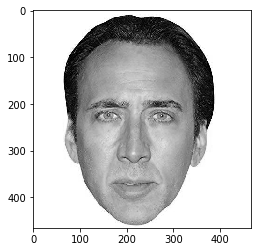

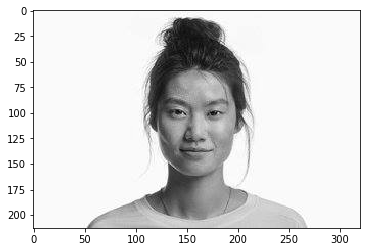

In [2]:
img1_f = './nick.jpg'
cage = cv2.cvtColor(cv2.imread(img1_f), cv2.COLOR_BGR2RGB)
img1 = cv2.cvtColor(cage, cv2.COLOR_BGR2GRAY)

img2_f = './face.jpg'
cage2 = cv2.cvtColor(cv2.imread(img2_f), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cage2, cv2.COLOR_BGR2GRAY)

plt.figure()
plt.imshow(img1, cmap='gray')

plt.figure()
plt.imshow(img2, cmap='gray')

Found 1 Faces!
Found 1 Faces!


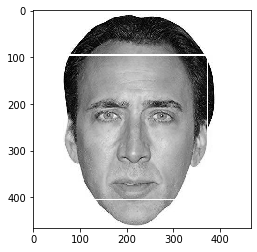

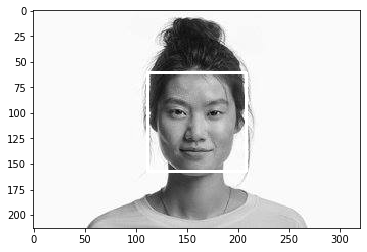

In [3]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
faces = face_cascade.detectMultiScale(
        img1,
        scaleFactor=1.3,
        minNeighbors=3,
        minSize=(30, 30)
)

print("Found {0} Faces!".format(len(faces)))

for (x, y, w, h) in faces:
    cv2.rectangle(img1, (x, y), (x+w, y+h), (255, 0, 0), 2)
    roi_img = cage[y:y+h, x:x+w]
    
    
plt.figure()
plt.imshow(img1, cmap='gray')


face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
faces = face_cascade.detectMultiScale(
        img2,
        scaleFactor=1.3,
        minNeighbors=3,
        minSize=(30, 30)
)

print("Found {0} Faces!".format(len(faces)))

for (x, y, w, h) in faces:
    cv2.rectangle(img2, (x, y), (x+w, y+h), (255, 0, 0), 2)
    roi_img = cage[y:y+h, x:x+w]

plt.figure()
plt.imshow(img2, cmap='gray')

In [4]:
# predictor = dlib.shape_predictor("shape_predictor_5_face_landmarks.dat")

# for (x, y, w, h) in faces:
        
#     cv2.rectangle(img1, (x, y), (x+w, y+h), (255, 0, 0), 2)
#     roi_img = cage[y:y+h, x:x+w]
    
#     landmarks = predictor(gray, roi_img)

#     for n in range(0, 5):
#         x = landmarks.part(n).x
#         y = landmarks.part(n).y
#         cv2.circle(cage, (x, y), 4, (255, 0, 0), -1)
    
# plt.figure()
# plt.imshow(img1, cmap='gray')
# plt.figure()
# plt.imshow(cage)

In [5]:
# import cv2
# import numpy as np
# import dlib

# cap = cv2.VideoCapture(0)

# detector = dlib.get_frontal_face_detector()
# predictor = dlib.shape_predictor("shape_predictor_5_face_landmarks.dat")

# while True:
#     _, frame = cap.read()
#     gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

#     faces = detector(gray)
#     for face in faces:
#         x1 = face.left()
#         y1 = face.top()
#         x2 = face.right()
#         y2 = face.bottom()

#         landmarks = predictor(gray, face)

#         for n in range(0, 5):
#             x = landmarks.part(n).x
#             y = landmarks.part(n).y
#             cv2.circle(frame, (x, y), 4, (255, 0, 0), -1)


#     cv2.imshow("Frame", frame)

#     key = cv2.waitKey(1)
#     if key == 27:
#         break

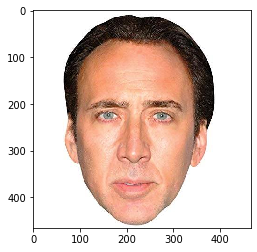

In [4]:
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
detector = dlib.get_frontal_face_detector()

gray = cv2.cvtColor(cage, cv2.COLOR_BGR2GRAY)
faces = detector(gray)

pts = np.zeros((len(faces),3,68))
for i, face in enumerate(faces):    
    x1 = face.left()
    y1 = face.top()
    x2 = face.right()
    y2 = face.bottom()

    landmarks = predictor(gray, face)

    for n in range(0, 68):
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        pts[i,0,n] = x
        pts[i,1,n] = y
        pts[i,2,n] = 1
#         cv2.circle(cage, (x, y), 4, (255, 0, 0), -1)
    
plt.imshow(cage)

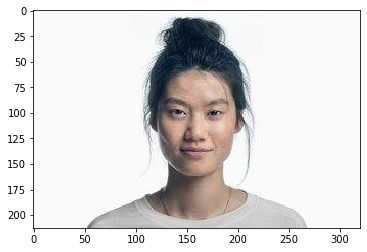

In [5]:
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
detector = dlib.get_frontal_face_detector()

gray = cv2.cvtColor(cage2, cv2.COLOR_BGR2GRAY)
faces = detector(gray)

pts2 = np.zeros((len(faces),3,68))
for i, face in enumerate(faces):    
    x1 = face.left()
    y1 = face.top()
    x2 = face.right()
    y2 = face.bottom()

    landmarks = predictor(gray, face)

    for n in range(0, 68):
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        pts2[i,0,n] = x
        pts2[i,1,n] = y
        pts2[i,2,n] = 1
#         cv2.circle(cage2, (x, y), 2, (255, 0, 0), -1)
    
plt.imshow(cage2)


In [7]:
def computeHomography(pts1, pts2):
    '''
    Compute homography that maps from pts1 to pts2 using least squares solver
     
    Input: pts1 and pts2 are 3xN matrices for N points in homogeneous
    coordinates. 
    
    Output: H is a 3x3 matrix, such that pts2~=H*pts1
    '''    
    # Normalization ops
    T_1   = np.eye(3) 
    T_1[:,-1] = np.array([-np.mean(pts1[0,:]), -np.mean(pts1[1,:]), 1])
    S_1 = np.diag(np.array([1/np.std(pts1[0,:]), 1/np.std(pts1[1,:]), 1])) 

    T_2 = np.eye(3) 
    T_2[:,-1] = np.array([-np.mean(pts2[0,:]), -np.mean(pts2[1,:]), 1])
    S_2 = np.diag(np.array([1/np.std(pts2[0,:]), 1/np.std(pts2[1,:]), 1])) 

    # Apply normalization
    pts1, pts2 = S_1 @ (T_1 @ pts1), S_2 @ (T_2 @ pts2)
    
    # Create A matrix
    A = np.zeros((pts1.shape[1]*2, 9))

    for i in range(pts1.shape[1]):   
        A[(2*i),:] = np.asarray([-pts1[0,i], -pts1[1,i], -1, 0, 0, 0, pts1[0,i]*pts2[0,i], pts1[1,i]*pts2[0,i], pts2[0,i]])
        A[(2*i)+1,:] = np.asarray([0,0,0, -pts1[0,i], -pts1[1,i],-1, pts1[0,i]*pts2[1,i], pts1[1,i]*pts2[1,i], pts2[1,i]])
    
    # SVD
    u,s,V = np.linalg.svd(A, full_matrices=True, compute_uv=True)
    H = V[-1,:].reshape((3, 3))
    H_ = (np.linalg.inv(T_2) @ (np.linalg.inv(S_2) @ ((H@S_1) @ T_1)))/H[2,2]
    
    return H_

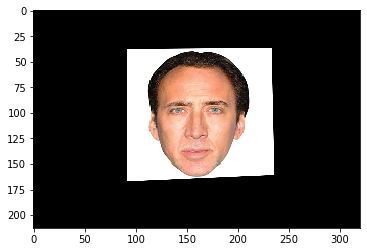

In [8]:
H12 = computeHomography(np.squeeze(pts), np.squeeze(pts2))
img1 = cv2.warpPerspective(cage, H12, dsize=(cage2.shape[1],cage2.shape[0]))
plt.imshow(img1)

In [9]:
def unit_v(p0, p1):
    a = (p0[0] - p1[0]); b = (p0[1] - p1[1])
    euler_dist = math.sqrt(a**2 + b**2)
    return a/euler_dist, b/euler_dist

def orth_v(vec):
    return -1*vec[1], vec[0]

def bounding_area(index, hull):
    unit_vector_p = unit_v(hull[index], hull[index+1])
    unit_vector_o = orth_v(unit_vector_p)

    dis_p = tuple(np.dot(unit_vector_p, pt) for pt in hull)
    dis_o = tuple(np.dot(unit_vector_o, pt) for pt in hull)

    min_p = min(dis_p)
    min_o = min(dis_o)
    len_p = max(dis_p) - min_p
    len_o = max(dis_o) - min_o

    return {'area': len_p * len_o,
            'length_parallel': len_p,
            'length_orthogonal': len_o,
            'rectangle_center': (min_p + len_p / 2, min_o + len_o / 2),
            'unit_vector': unit_vector_p,
            }

def to_xy_coordinates(unit_vector_angle, point):
    # returns converted unit vector coordinates in x, y coordinates
    angle_orthogonal = unit_vector_angle + math.pi / 2
    return point[0] * math.cos(unit_vector_angle) + point[1] * math.cos(angle_orthogonal), \
           point[0] * math.sin(unit_vector_angle) + point[1] * math.sin(angle_orthogonal)

def rotate_points(center_of_rotation, angle, points):
    # Requires: center_of_rotation to be a 2d vector. ex: (1.56, -23.4)
    #           angle to be in radians
    #           points to be a list or tuple of points. ex: ((1.56, -23.4), (1.56, -23.4))
    # Effects: rotates a point cloud around the center_of_rotation point by angle
    rot_points = []
    ang = []
    for pt in points:
        diff = tuple([pt[d] - center_of_rotation[d] for d in range(2)])
        diff_angle = math.atan2(diff[1], diff[0]) + angle
        ang.append(diff_angle)
        diff_length = math.sqrt(sum([d**2 for d in diff]))
        rot_points.append((center_of_rotation[0] + diff_length * math.cos(diff_angle),
                           center_of_rotation[1] + diff_length * math.sin(diff_angle)))
    return rot_points

def rectangle_corners(rectangle):
    # Requires: the output of mon_bounding_rectangle
    # Effects: returns the corner locations of the bounding rectangle
    corner_points = []
    for i1 in (.5, -.5):
        for i2 in (i1, -1 * i1):
            corner_points.append((rectangle['rectangle_center'][0] + i1 * rectangle['length_parallel'],
                            rectangle['rectangle_center'][1] + i2 * rectangle['length_orthogonal']))
    return rotate_points(rectangle['rectangle_center'], rectangle['unit_vector_angle'], corner_points)

def min_bbox(points):
    ordered_hull_points = [points[index] for index in ConvexHull(points).vertices]
    ordered_hull_points.append(ordered_hull_points[0])
    ordered_hull_points = tuple(ordered_hull_points)
    
    min_rectangle = bounding_area(0, ordered_hull_points)
    for i in range(1, len(ordered_hull_points)-1):
        rectangle = bounding_area(i, ordered_hull_points)
        if rectangle['area'] < min_rectangle['area']:
            min_rectangle = rectangle
    min_rectangle['unit_vector_angle'] = math.atan2(min_rectangle['unit_vector'][1], min_rectangle['unit_vector'][0])
    min_rectangle['rectangle_center'] = to_xy_coordinates(min_rectangle['unit_vector_angle'], min_rectangle['rectangle_center'])
    
    return np.array(rectangle_corners(min_rectangle))
    
def calculate_convex_mask(pts, img):
    
    points = tuple(map(tuple, pts[0:2,:].T))
    
    convex_hull = [points[index] for index in ConvexHull(points).vertices]
    item = (convex_hull[0][0], convex_hull[0][1])
    convex_hull.append(item)
    convex_hull = np.array(convex_hull, dtype='int32')
    
    mask = np.zeros(img.shape[0:2],dtype=np.uint8)
    
    cv2.fillPoly(mask, [convex_hull], 1)
    
    return mask.astype(np.uint8), convex_hull

In [10]:
def alpha_blending(frame, pts1, mask, std=4):
    
    bg = np.ones((frame.shape[0], frame.shape[1]))
    fg = np.ones((frame.shape[0], frame.shape[1]))
    
    # Face 1 box
    x1 = int(np.min(pts1[0,1,:]))
    y1 = int(np.min(pts1[0,0,:]))
    h1 = int(np.max(pts1[0,1,:]) - x1)
    w1 = int(np.max(pts1[0,0,:]) - y1)
    
    x = cv2.getGaussianKernel(int(h1), h1//std)
    y = cv2.getGaussianKernel(int(w1), w1//std)
    kernel1 = x.dot(y.T)
    kernel1 = kernel1/np.max(kernel1)
    
    # Face 2 box
    x2 = int(np.min(pts1[1,1,:]))
    y2 = int(np.min(pts1[1,0,:]))
    h2 = int(np.max(pts1[1,1,:]) - x2)
    w2 = int(np.max(pts1[1,0,:]) - y2)
    
    x = cv2.getGaussianKernel(int(h2), h2//std)
    y = cv2.getGaussianKernel(int(w2), w2//std)
    kernel2 = x.dot(y.T)    
    kernel2 = kernel2/np.max(kernel2)

#     print(x2,y2,h2,w2)
    
    bg[x1:x1+h1,y1:y1+w1] = (1-kernel1) * mask[x1:x1+h1,y1:y1+w1]
    bg[x2:x2+h2,y2:y2+w2] = (1-kernel2) * mask[x2:x2+h2,y2:y2+w2]
    bg[bg == 0] = 1
#     plt.figure()
#     plt.imshow(bg)
    
    fg[x1:x1+h1,y1:y1+w1] = kernel1 * mask[x1:x1+h1,y1:y1+w1]
    fg[x2:x2+h2,y2:y2+w2] = kernel2 * mask[x2:x2+h2,y2:y2+w2]
    fg[fg == 0] = 1

#     plt.figure()
#     plt.imshow(fg)
    
    
    return np.expand_dims(bg, axis=-1), np.expand_dims(fg, axis=-1)


# bg, fg = alpha_blending(cage, pts, mask)
# plt.figure()
# plt.imshow(bg)
# plt.figure()
# plt.imshow(fg)
# print(np.max(fg))

In [23]:
# x_min = int(np.min(pts2[:,0,:]))
# x_max = int(np.max(pts2[:,0,:]))
# y_min = int(np.min(pts2[:,1,:]))
# y_max = int(np.max(pts2[:,1,:]))

# mask = np.zeros((img1.shape[0], img1.shape[1]))
# mask[y_min:y_max, x_min:x_max] = 1

mask, _ = calculate_convex_mask(pts2[0],cage2)
# bg, fg = alpha_blending(cage, np.array([pts,pts2]), mask)

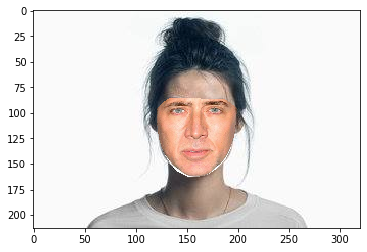

In [24]:
plt.imshow(img1*(mask[:,:,None].astype(int)) + cage2*(1-mask[:,:,None].astype(int)))

In [12]:
import cv2
import numpy as np
import dlib

cap = cv2.VideoCapture(0)

predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
detector = dlib.get_frontal_face_detector()

while True:
    _, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)    
    
    pts2 = np.zeros((len(faces),3,68))
    for i, face in enumerate(faces):    
        x1 = face.left()
        y1 = face.top()
        x2 = face.right()
        y2 = face.bottom()

        landmarks = predictor(gray, face)

        for n in range(0, 68):
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            pts2[i,0,n] = x
            pts2[i,1,n] = y
            pts2[i,2,n] = 1

            
        H12 = computeHomography(np.squeeze(pts), np.squeeze(pts2))
        img1 = cv2.warpPerspective(cage, H12, dsize=(frame.shape[1],frame.shape[0]))
        x_min = int(np.min(pts2[:,0,:]))
        x_max = int(np.max(pts2[:,0,:]))
        y_min = int(np.min(pts2[:,1,:]))
        y_max = int(np.max(pts2[:,1,:]))

        mask = np.zeros((frame.shape[0], frame.shape[1],1))
        mask[y_min:y_max, x_min:x_max,:] = 1
        
        frame = img1[:,:,::-1].astype(int)*(mask.astype(int)) + frame*(1-mask.astype(int))

    cv2.imshow("Frame", frame.astype(np.uint8))

    key = cv2.waitKey(33)
    if key == 27:
        break

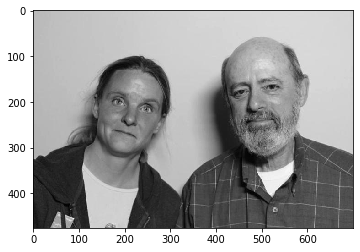

In [27]:
img_f = './two_face.jpg'
cage = cv2.cvtColor(cv2.imread(img_f), cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(cage, cv2.COLOR_BGR2GRAY)

plt.figure()
plt.imshow(img, cmap='gray')

Found 2 Faces!


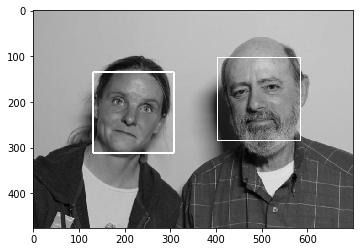

In [28]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
faces = face_cascade.detectMultiScale(
        img,
        scaleFactor=1.3,
        minNeighbors=3,
        minSize=(30, 30)
)

print("Found {0} Faces!".format(len(faces)))

for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
    roi_img = cage[y:y+h, x:x+w]
    
    
plt.figure()
plt.imshow(img, cmap='gray')

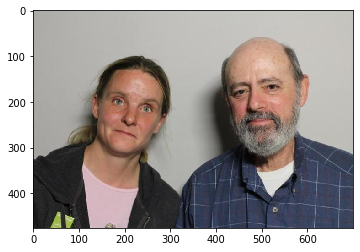

In [29]:
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
detector = dlib.get_frontal_face_detector()

gray = cv2.cvtColor(cage, cv2.COLOR_BGR2GRAY)
faces = detector(gray)

pts = np.zeros((len(faces),3,68))
for i, face in enumerate(faces):    
    x1 = face.left()
    y1 = face.top()
    x2 = face.right()
    y2 = face.bottom()

    landmarks = predictor(gray, face)

    for n in range(0, 68):
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        pts[i,0,n] = x
        pts[i,1,n] = y
        pts[i,2,n] = 1
#         cv2.circle(cage, (x, y), 4, (255, 0, 0), -1)
    
plt.imshow(cage)

In [30]:
def computeHomography(pts1, pts2):
    '''
    Compute homography that maps from pts1 to pts2 using least squares solver
     
    Input: pts1 and pts2 are 3xN matrices for N points in homogeneous
    coordinates. 
    
    Output: H is a 3x3 matrix, such that pts2~=H*pts1
    '''    
    # Normalization ops
    T_1   = np.eye(3) 
    T_1[:,-1] = np.array([-np.mean(pts1[0,:]), -np.mean(pts1[1,:]), 1])
    S_1 = np.diag(np.array([1/np.std(pts1[0,:]), 1/np.std(pts1[1,:]), 1])) 

    T_2 = np.eye(3) 
    T_2[:,-1] = np.array([-np.mean(pts2[0,:]), -np.mean(pts2[1,:]), 1])
    S_2 = np.diag(np.array([1/np.std(pts2[0,:]), 1/np.std(pts2[1,:]), 1])) 

    # Apply normalization
    pts1, pts2 = S_1 @ (T_1 @ pts1), S_2 @ (T_2 @ pts2)
    
    # Create A matrix
    A = np.zeros((pts1.shape[1]*2, 9))

    for i in range(pts1.shape[1]):   
        A[(2*i),:] = np.asarray([-pts1[0,i], -pts1[1,i], -1, 0, 0, 0, pts1[0,i]*pts2[0,i], pts1[1,i]*pts2[0,i], pts2[0,i]])
        A[(2*i)+1,:] = np.asarray([0,0,0, -pts1[0,i], -pts1[1,i],-1, pts1[0,i]*pts2[1,i], pts1[1,i]*pts2[1,i], pts2[1,i]])
    
    # SVD
    u,s,V = np.linalg.svd(A, full_matrices=True, compute_uv=True)
    H = V[-1,:].reshape((3, 3))
    H_ = (np.linalg.inv(T_2) @ (np.linalg.inv(S_2) @ ((H@S_1) @ T_1)))/H[2,2]
    
    return H_

[[   1.39754836   -0.01297525 -477.03439615]
 [   0.96378976    1.22933008 -494.4225499 ]
 [   0.00277163    0.00171567   -0.73855848]]
[[ -0.16133127  -0.99449125 763.97843027]
 [ -0.89720967   0.42250089 296.63807511]
 [ -0.00242939  -0.00298335   2.22860292]]


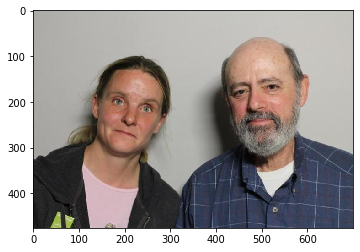

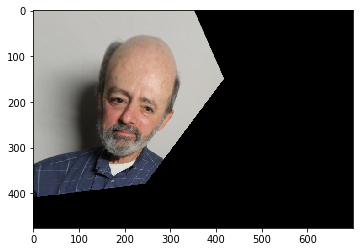

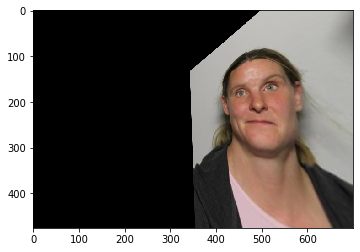

In [31]:
H12 = computeHomography(np.squeeze(pts[0]), np.squeeze(pts[1]))
H21 = computeHomography(np.squeeze(pts[1]), np.squeeze(pts[0]))
print(H12)
print(H21)
face1 = cv2.warpPerspective(cage, H12, dsize=(cage.shape[1],cage.shape[0]))
face2 = cv2.warpPerspective(cage, H21, dsize=(cage.shape[1],cage.shape[0]))
plt.figure()
plt.imshow(cage)
plt.figure()
plt.imshow(face1)
plt.figure()
plt.imshow(face2)

In [41]:
def unit_v(p0, p1):
    a = (p0[0] - p1[0]); b = (p0[1] - p1[1])
    euler_dist = math.sqrt(a**2 + b**2)
    return a/euler_dist, b/euler_dist

def orth_v(vec):
    return -1*vec[1], vec[0]

def bounding_area(index, hull):
    unit_vector_p = unit_v(hull[index], hull[index+1])
    unit_vector_o = orth_v(unit_vector_p)

    dis_p = tuple(np.dot(unit_vector_p, pt) for pt in hull)
    dis_o = tuple(np.dot(unit_vector_o, pt) for pt in hull)

    min_p = min(dis_p)
    min_o = min(dis_o)
    len_p = max(dis_p) - min_p
    len_o = max(dis_o) - min_o

    return {'area': len_p * len_o,
            'length_parallel': len_p,
            'length_orthogonal': len_o,
            'rectangle_center': (min_p + len_p / 2, min_o + len_o / 2),
            'unit_vector': unit_vector_p,
            }

def to_xy_coordinates(unit_vector_angle, point):
    # returns converted unit vector coordinates in x, y coordinates
    angle_orthogonal = unit_vector_angle + math.pi / 2
    return point[0] * math.cos(unit_vector_angle) + point[1] * math.cos(angle_orthogonal), \
           point[0] * math.sin(unit_vector_angle) + point[1] * math.sin(angle_orthogonal)

def rotate_points(center_of_rotation, angle, points):
    # Requires: center_of_rotation to be a 2d vector. ex: (1.56, -23.4)
    #           angle to be in radians
    #           points to be a list or tuple of points. ex: ((1.56, -23.4), (1.56, -23.4))
    # Effects: rotates a point cloud around the center_of_rotation point by angle
    rot_points = []
    ang = []
    for pt in points:
        diff = tuple([pt[d] - center_of_rotation[d] for d in range(2)])
        diff_angle = math.atan2(diff[1], diff[0]) + angle
        ang.append(diff_angle)
        diff_length = math.sqrt(sum([d**2 for d in diff]))
        rot_points.append((center_of_rotation[0] + diff_length * math.cos(diff_angle),
                           center_of_rotation[1] + diff_length * math.sin(diff_angle)))
    return rot_points

def rectangle_corners(rectangle):
    # Requires: the output of mon_bounding_rectangle
    # Effects: returns the corner locations of the bounding rectangle
    corner_points = []
    for i1 in (.5, -.5):
        for i2 in (i1, -1 * i1):
            corner_points.append((rectangle['rectangle_center'][0] + i1 * rectangle['length_parallel'],
                            rectangle['rectangle_center'][1] + i2 * rectangle['length_orthogonal']))
    return rotate_points(rectangle['rectangle_center'], rectangle['unit_vector_angle'], corner_points)

def min_bbox(points):
    ordered_hull_points = [points[index] for index in ConvexHull(points).vertices]
    ordered_hull_points.append(ordered_hull_points[0])
    ordered_hull_points = tuple(ordered_hull_points)
    
    min_rectangle = bounding_area(0, ordered_hull_points)
    for i in range(1, len(ordered_hull_points)-1):
        rectangle = bounding_area(i, ordered_hull_points)
        if rectangle['area'] < min_rectangle['area']:
            min_rectangle = rectangle
    min_rectangle['unit_vector_angle'] = math.atan2(min_rectangle['unit_vector'][1], min_rectangle['unit_vector'][0])
    min_rectangle['rectangle_center'] = to_xy_coordinates(min_rectangle['unit_vector_angle'], min_rectangle['rectangle_center'])
    
    return np.array(rectangle_corners(min_rectangle))
    
def calculate_bbox(pts,img, debug=False):
#     if debug_img is not None:
#         img_copy = np.copy(debug_img)
#     for i in range(pts.shape[-1]):
#         if debug_img is not None: cv2.circle(img_copy, (int(pts[0,i]), int(pts[1,i])), 3, (255, 0, 0), -1)
#     if debug is True:
#         plt.figure()
#         plt.imshow(img_copy)
    img_copy = np.copy(img)    
#     print(pts[0:2,:].shape)
    points = tuple(map(tuple, pts[0:2,:].T))
    min_rect = min_bbox(points)
#     print('min rect:\n', min_rect)
    
#     if debug is True:
#     print(min_rect[:,0].shape)
#     print(min_rect[0,0].shape)
    
    rpts_0 = np.append(min_rect[:,0], min_rect[0,0])
    rpts_1 = np.append(min_rect[:,1], min_rect[0,1])
    
    convex_hull = [points[index] for index in ConvexHull(points).vertices]
    item = (convex_hull[0][0], convex_hull[0][1])
    convex_hull.append(item)
#         print(convex_hull[0,:])
#         convex_hull = np.append(convex_hull, convex_hull[0,:])
#         print(convex_hull)
    convex_hull = np.array(convex_hull, dtype='int32')
    
#     plt.figure()
#     plt.imshow(img_copy)
#     plt.plot(convex_hull[:,0], convex_hull[:,1], 'r')
#     plt.show()
    
    mask = np.zeros(img_copy.shape[0:2],dtype=np.uint8)
    
#     print(convex_hull)
    
    cv2.fillPoly(mask, [convex_hull], 1)
#     plt.figure()
#     plt.imshow(mask, cmap='gray')

#     mask = np.where(mask > 0.5, 1, 0)
    
    return mask.astype(np.uint8), convex_hull

In [42]:
# x1_min = int(np.min(pts[1,0,:]))
# x1_max = int(np.max(pts[1,0,:]))
# y1_min = int(np.min(pts[1,1,:]))
# y1_max = int(np.max(pts[1,1,:]))

# mask1 = np.zeros((img.shape[0], img.shape[1]))
# mask1[y1_min:y1_max, x1_min:x1_max] = 1

# x2_min = int(np.min(pts[0,0,:]))
# x2_max = int(np.max(pts[0,0,:]))
# y2_min = int(np.min(pts[0,1,:]))
# y2_max = int(np.max(pts[0,1,:]))

# mask2 = np.zeros((img.shape[0], img.shape[1]))
# mask2[y2_min:y2_max, x2_min:x2_max] = 1

# mask = mask1 + mask2

mask1, _ = calculate_bbox(pts[1],cage)
mask2, _ = calculate_bbox(pts[0],cage)

mask = np.bitwise_or(mask1,mask2)

print(mask)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


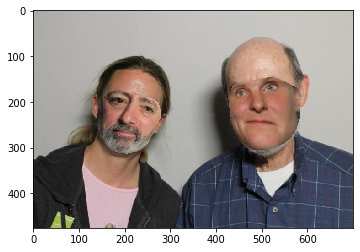

In [43]:
plt.imshow(face1*(mask1[:,:,None].astype(int)) + face2*(mask2[:,:,None].astype(int)) + cage*(1-mask[:,:,None].astype(int)))

In [62]:
import cv2
import numpy as np
import dlib

cap = cv2.VideoCapture(0)

predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
detector = dlib.get_frontal_face_detector()

while True:
    _, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)    
    print(len(faces))
    
    pts = np.zeros((len(faces),3,68))
    for i, face in enumerate(faces):    
        x1 = face.left()
        y1 = face.top()
        x2 = face.right()
        y2 = face.bottom()

        landmarks = predictor(gray, face)

        for n in range(0, 68):
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            pts[i,0,n] = x
            pts[i,1,n] = y
            pts[i,2,n] = 1

            
    H12 = computeHomography(np.squeeze(pts[0]), np.squeeze(pts[1]))
    H21 = computeHomography(np.squeeze(pts[1]), np.squeeze(pts[0]))
    
    face1 = cv2.warpPerspective(frame, H12, dsize=(frame.shape[1],frame.shape[0]))
    face2 = cv2.warpPerspective(frame, H21, dsize=(frame.shape[1],frame.shape[0]))
    
    x1_min = int(np.min(pts[1,0,:]))
    x1_max = int(np.max(pts[1,0,:]))
    y1_min = int(np.min(pts[1,1,:]))
    y1_max = int(np.max(pts[1,1,:]))
    
    mask1 = np.zeros((frame.shape[0], frame.shape[1],1))
    mask1[y1_min:y1_max, x1_min:x1_max,:] = 1
    
    x2_min = int(np.min(pts[0,0,:]))
    x2_max = int(np.max(pts[0,0,:]))
    y2_min = int(np.min(pts[0,1,:]))
    y2_max = int(np.max(pts[0,1,:]))
    
    mask2 = np.zeros((frame.shape[0], frame.shape[1],1))
    mask2[y2_min:y2_max, x2_min:x2_max,:] = 1
    
    mask = mask1 + mask2
    
    frame = face1.astype(int)*(mask1.astype(int)) + face2.astype(int)*(mask2.astype(int)) + frame*(1-mask.astype(int))

    cv2.imshow("Frame", frame.astype(np.uint8))

    key = cv2.waitKey(33)
    if key == 27:
        break

2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
1


IndexError: index 1 is out of bounds for axis 0 with size 1